In [196]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator, Sampler
from qiskit_aer.noise import NoiseModel

from squlearn import Executor
from squlearn.encoding_circuit import QiskitEncodingCircuit
from squlearn.observables import SinglePauli
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam, SLSQP, SGLBO

import matplotlib.pyplot as plt
import matplotlib as mpl

In [197]:
nqubits = 4

qc = QuantumCircuit(4)
p = ParameterVector('p', 8)
x = ParameterVector('x', 1)

p2 = np.array([1.47555363,  0.32743475,  1.47644471,  1.58626061,  0.97260111,  0.45344925,
 -0.01201612,  0.77552651])

qc.h(range(nqubits))

qc.rz(p[0], 0)
qc.rz(p2[3], 1)
qc.rz(p2[1], 2)
qc.rz(p2[2], 3)

qc.rx(1*np.arccos(x[0]), 0)
qc.rx(2*np.arccos(x[0]), 1)
qc.rx(3*np.arccos(x[0]), 2)
qc.rx(4*np.arccos(x[0]), 3)

qc.cx(0, 1)
qc.cx(2, 3)
qc.cx(1, 2)
qc.cx(3, 0)

qc.ry(p2[6], 0)
qc.ry(p2[5], 1)
qc.ry(p2[7], 2)
qc.ry(p2[4], 3)


pqc = QiskitEncodingCircuit(qc)

pqc.draw()

┌───┐  ┌──────────┐  ┌────────────────┐           ┌───┐┌───────────────┐
q_0: ┤ H ├──┤ Rz(p[0]) ├──┤ Rx(acos(x[0])) ├───■───────┤ X ├┤ Ry(-0.012016) ├
     ├───┤ ┌┴──────────┴┐┌┴────────────────┴┐┌─┴─┐     └─┬─┘└┬─────────────┬┘
q_1: ┤ H ├─┤ Rz(1.5863) ├┤ Rx(2*acos(x[0])) ├┤ X ├──■────┼───┤ Ry(0.45345) ├─
     ├───┤┌┴────────────┤├──────────────────┤└───┘┌─┴─┐  │   ├─────────────┤ 
q_2: ┤ H ├┤ Rz(0.32743) ├┤ Rx(3*acos(x[0])) ├──■──┤ X ├──┼───┤ Ry(0.77553) ├─
     ├───┤└┬────────────┤├──────────────────┤┌─┴─┐└───┘  │   └┬────────────┤ 
q_3: ┤ H ├─┤ Rz(1.4764) ├┤ Rx(4*acos(x[0])) ├┤ X ├───────■────┤ Ry(0.9726) ├─
     └───┘ └────────────┘└──────────────────┘└───┘            └────────────┘

In [198]:
op = SinglePauli(nqubits,qubit=0,parameterized=True)
print(op)

SparsePauliOp(['IIIZ'],
              coeffs=[ParameterExpression(1.0*p[0])])


In [199]:
op.num_parameters

1

In [200]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(13) #13
param_ini =  np.random.rand(pqc.num_parameters)
# Initialize parameters of the observable as ones
param_op_ini = np.ones(op.num_parameters)
x0 = [[i * 0.02] for i in range(15)]
optimizer_options = {"bo_aqc_func": "EI", "bo_aqc_optimizer": "lbfgs", "bo_bounds": [(0.0, 0.3)], "log_file": "sglbo_noiseless.log",
                     "bo_n_calls": 30, "bo_x0_points": x0, "maxiter": 100, "bo_bounds_fac": 0.1}

qnn_simulator = QNNRegressor(
    pqc,
    op,
    Executor("statevector_simulator"),
    SquaredLoss(),
    #SGLBO(optimizer_options),
    #SLSQP(),
    Adam({"lr": 0.1,"log_file": "adam_noiseless.log"}),
    param_ini,
    param_op_ini=param_op_ini,
    opt_param_op=True, # Keine Observablen optimierung
    parameter_seed=124
)

In [201]:
print(param_ini)
print(param_op_ini)

[0.77770241]
[1.]


In [202]:
# Data that is inputted to the QNN
x_train = np.arange(-0.5, 0.6, 0.1)
# Data that is fitted by the QNN
y_train = np.sin(6.0*x_train)

In [203]:
def evaluate_loss(theta, qnn_regressor: QNNRegressor, X, y):
    param = theta[: qnn_regressor._qnn.num_parameters]
    param_op = theta[qnn_regressor._qnn.num_parameters :]

    loss_values = qnn_regressor._qnn.evaluate(qnn_regressor.loss.loss_args_tuple, X, param, param_op)

    loss_value = qnn_regressor.loss.value(
        loss_values,
        ground_truth=y,
        weights=np.ones(len(y)),
        iteration=0,
    )

    return loss_value




In [204]:
qnn_simulator.fit(x_train, y_train)

fit: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]

In [205]:
qnn_simulator.param

array([1.47717799])

In [206]:
qnn_simulator.param_op

array([5.39864545])

In [207]:
evaluate_loss([qnn_simulator.param,qnn_simulator.param_op], qnn_simulator, x_train, y_train)

0.11120010694363783

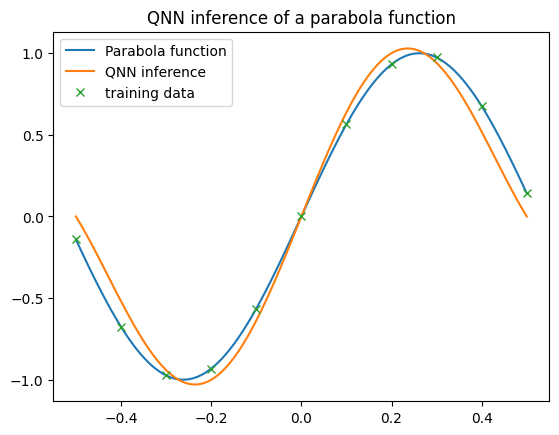

In [208]:
x = np.arange(np.min(x_train), np.max(x_train) + 0.01, 0.01)
y = qnn_simulator.predict(x)  # function for evaluating the prediction of the QNN
plt.plot(x, np.sin(6.0*x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference of a parabola function")
plt.show()

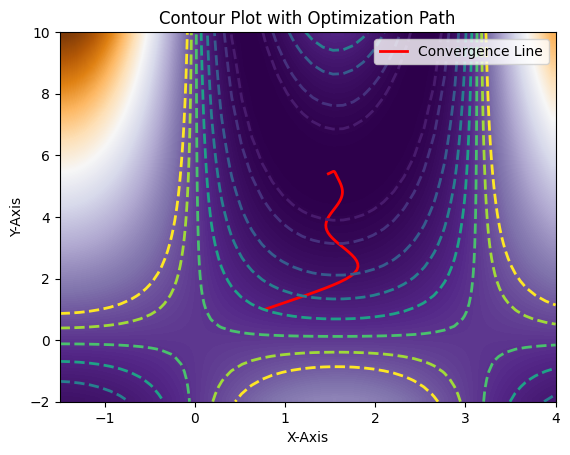

In [209]:
# Lese die Optimierungskoordinaten aus der Datei "params.log"
optimization_data = np.loadtxt("sglbo_noiseless_params2.log")
optimization_x = optimization_data[:, 0]
optimization_y = optimization_data[:, 1]

# plot the decision function for each datapoint on the grid
xx, yy = np.meshgrid(np.linspace(-1.5, 4, 50), np.linspace(-2, 10, 50))
Z = []
for i in range(len(xx)):
    for j in range(len(xx[i])):
        param = np.array([xx[i][j], yy[i][j]])
        Z.append(evaluate_loss(param, qnn_simulator, x_train, y_train))

Z = np.array(Z)
Z = Z.reshape(xx.shape)
#norm = mpl.colors.Normalize(vmin=-max(abs(np.min(Z)),abs(np.max(Z))), vmax=max(abs(np.min(Z)),abs(np.max(Z))))
im = plt.imshow(
    Z,
    interpolation="bilinear",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
    #norm=norm
)

# Verbinde die Punkte im Scatter Plot mit einer Linie
plt.plot(optimization_x, optimization_y, c='red', linestyle='-', linewidth=2, label='Convergence Line')

# Plot backtransformed hyperplane
contours = plt.contour(xx, yy, Z, levels=[0,0.5,1,2,3,4,5,6,7], linewidths=2, linestyles="dashed")

# Plot training data
plt.axis([-1.5, 4, -2, 10])
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Contour Plot with Optimization Path')
plt.legend()
plt.show()